> Here, we use GA to adjust the structure of Logic Controller.

In [1]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset(self, s=[]):
        if np.array( s ).shape[0] == 0:
            self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
            while ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 ):
                self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            while (  ( abs(self.obstacle_x-self.target_x) < 1.05 ) & ( abs(self.obstacle_y-self.target_y) < 1.05 )  ) |\
             (  ( abs(self.move_x-self.target_x) < 1.05 ) & ( abs(self.move_y-self.target_y) < 1.05 )  ):
                self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        
        else:
            self.obstacle_x=s[0]
            self.obstacle_y=s[1]
            self.target_x=s[2]
            self.target_y=s[3]
            self.move_x=s[4]
            self.move_y=s[5]

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])
        return state #, self.state2img(state)
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

#         if self.move_x > (self.scope+1.0):
#             self.move_x-=velocity
#         if self.move_x < (-self.scope-1.0):
#             self.move_x+=velocity
#         if self.move_y > (self.scope+1.0):
#             self.move_y-=velocity
#         if self.move_y < (-self.scope-1.0):
#             self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.05 ) & ( abs(self.target_y-self.move_y) < 1.05 )  ):
            reward = 1.0
            done = True
            info = "reach"

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])

        return state, reward,done,info
    def state2img(self, state):
        img = np.zeros([84,84,3], dtype=np.uint8)
        ( img[ int(42-(self.obstacle_y+0.5)*10):int(42-(self.obstacle_y-0.5)*10), int((self.obstacle_x-0.5)*10+42):int((self.obstacle_x+0.5)*10+42),2 ] ).fill(255)
        ( img[ int(42-(self.target_y+0.5)*10):int(42-(self.target_y-0.5)*10), int((self.target_x-0.5)*10+42):int((self.target_x+0.5)*10+42),1 ] ).fill(255)
        ( img[ int(42-(self.move_y+0.5)*10):int(42-(self.move_y-0.5)*10), int((self.move_x-0.5)*10+42):int((self.move_x+0.5)*10+42),0 ] ).fill(255)
        return img

In [2]:
import tensorflow as tf
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = env.states

        # self.action_dim = env.action_space.n
        self.action_dim = env.actions

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        
#         # # a: create new network weights
#         print "create new network weights ..."
#         num_hid = 200
#         self.W1 = self.weight_variable([self.state_dim,num_hid])
#         self.b1 = self.bias_variable([num_hid])
#         self.W2 = self.weight_variable([num_hid,num_hid])
#         self.b2 = self.bias_variable([num_hid])
#         self.W3 = self.weight_variable([num_hid,self.action_dim])
#         self.b3= self.bias_variable([self.action_dim])

        # # b: restore old network weights
        print "restore old network weights ..."
        self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.restore_wb( "train-3500/" )


        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
        h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() <= 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self, directory):
        W1 = np.load( directory+"W1.npy" )
        W2 = np.load( directory+"W2.npy" )
        W3 = np.load( directory+"W3.npy" )

        b1 = np.load( directory+"b1.npy" )
        b2 = np.load( directory+"b2.npy" )
        b3 = np.load( directory+"b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

restore old network weights ...


In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
logic_q = np.load( 'logic_q-1.02-4-adjust-10.npy' )
discrete = np.array( [0., 1.02, 1.86, 2.93, 4.1, 95.03] )

In [5]:
state = env.reset( [ -0.8, -0.6, -2.0, -1.6,1.9, 1.7] )
A = [state]
print state.tolist(),
for j in xrange(STEP):
    action = agent.action(state)
    
    state, reward,done,info = env.step(action)
    A.append(state)
    print '--', action, '->', state.tolist(),
    if done:
        print info
        break

[-0.8, -0.6, -2.0, -1.6, 1.9, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 1.7, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 1.5, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 1.3, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 1.1, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 0.9000000000000001, 1.7] -- 3 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 1.7] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 1.5] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 1.3] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 1.1] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 0.9000000000000001] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 0.7000000000000002] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 0.5000000000000002] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 0.3000000000000002] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, 0.1000000000000002] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, -0.09999999999999981] -- 1 -> [-0.8, -0.6, -2.0, -1.6, 0.7000000000000002, -0.2999999

In [6]:
def state2relative(state):
    obstacle = np.array( state[0] )
    target = np.array( state[1] )
    agent = np.array( state[2][0] )
#     print agent
    
    top_t = 100.0
    bottom_t = 100.0
    right_t = 100.0
    left_t = 100.0

    top_o = 100.0
    bottom_o = 100.0
    right_o = 100.0
    left_o = 100.0        
#     print obstacle
#     print obstacle[:,1]
#     print abs(obstacle[:,1]-agent[1])
    obstacle_x=obstacle[np.argmin( abs(obstacle[:,0]-agent[0]) ),0]
    obstacle_y=obstacle[np.argmin( abs(obstacle[:,1]-agent[1]) ),1]
    target_x=target[np.argmin( abs(target[:,0]-agent[0]) ),0]
    target_y=target[np.argmin( abs(target[:,1]-agent[1]) ),1]
    move_x=agent[0]
    move_y=agent[1]

    if target_y >= move_y:
        top_t = target_y - move_y
    if target_y < move_y:
        bottom_t = move_y - target_y
    if target_x >= move_x:
        right_t = target_x - move_x
    if target_x < move_x:
        left_t = move_x - target_x

    if obstacle_y >= move_y:
        top_o = obstacle_y - move_y
    if obstacle_y < move_y:
        bottom_o = move_y - obstacle_y
    if obstacle_x >= move_x:
        right_o = obstacle_x - move_x
    if obstacle_x < move_x:
        left_o = move_x - obstacle_x

    return np.array([ top_t, bottom_t, right_t, left_t, top_o, bottom_o, right_o, left_o ])

In [8]:
def discrete_it(state, discrete):
    
    dis_s = []
    for i in xrange( len(state) ):
        num = state[i]
        over = num - discrete
        for j in xrange( len(over) ):
            if over[j]<0:
                over[j] = 100 # a certain big number
        dis_s.append( np.argmin( over ) )
    return dis_s

In [29]:

state = env.reset( [ 0.0, -1.0, -2.0, -0.0,1.9, 1.7 ] )
obstacle_02=[state[0:2], [0.0, 1.0]]

# state = env.reset( [ -0.8, -0.6, -2.0, -1.6,1.9, 1.7 ] )
# obstacle_02=[state[0:2]]

A = [state]
old_action = 1.5
print state.tolist(),
for j in xrange(STEP):
    relative_state=state2relative( [ obstacle_02, [state[2:4]], [state[4:]] ] )
    # discrete it:
    relative_state = discrete_it( relative_state, discrete )
    print relative_state
    action = np.argmax( logic_q[relative_state[0]][relative_state[1]][relative_state[2]][relative_state[3]]\
    [relative_state[4]][relative_state[5]][relative_state[6]][relative_state[7]] )-1
    
    if (((relative_state[0]+relative_state[4])==0) | ((relative_state[1]+relative_state[5])==0)) & (action<1.2) & (old_action<1.2):
    #             print "^^^"
        action = old_action
    if (((relative_state[2]+relative_state[6])==0) | ((relative_state[3]+relative_state[7])==0)) & (action>1.8) & (old_action>1.8):
    #             print "%%%"
        action = old_action

    old_action = action
    
    state, reward,done,info = env.step(action)
    A.append(state)
    print '--', action, '->', state.tolist(),
    if done:
        print "info: ", info
        break

[0.0, -1.0, -2.0, -0.0, 1.9, 1.7] [5, 1, 5, 3, 5, 0, 5, 2]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.9, 1.5] [5, 1, 5, 3, 5, 0, 5, 2]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.9, 1.3] [5, 1, 5, 3, 5, 0, 5, 2]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.9, 1.1] [5, 1, 5, 3, 5, 0, 5, 2]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.9, 0.9000000000000001] [5, 0, 5, 3, 0, 5, 5, 2]
-- 3 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.9000000000000001] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.7000000000000002] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.5000000000000002] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.3000000000000002] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.1000000000000002] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, -0.09999999999999981] [0, 5, 5, 3, 5, 0, 5, 1]
-- 0 -> [0.0, -1.0, -2.0, -0.0, 1.7, 0.1000000000000002] [5, 0, 5, 3, 0, 5, 5, 1]
-- 1 -> [0.0, -1.0, -2.0, -0.0, 1.7, -0.09999999999999981] [0, 5, 5, 3, 5, 0, 5, 1

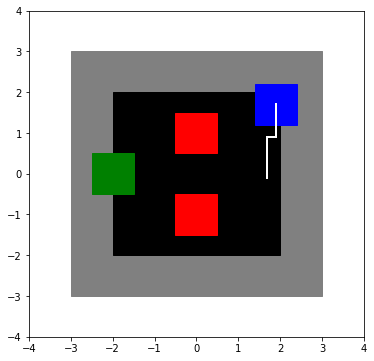

In [33]:
if True:
    fig = plt.figure( figsize=(6,6) )
    ax = fig.add_subplot(111)

    ax.add_patch(
        patches.Rectangle(
            (-3, -3),
            6,
            6,
            color="grey"
        )
    )
    ax.add_patch(
        patches.Rectangle(
            (-2, -2),
            4,
            4,
            color="black"
        )
    )

    
    for i in range( len(obstacle_02) ):
        ax.add_patch(
            patches.Rectangle(
                (obstacle_02[i][0]-0.5, obstacle_02[i][1]-0.5),
                1,
                1,
                color="red",
                hatch="x"
            )
        )
    

    ax.add_patch(
        patches.Rectangle(
            (A[0][2]-0.5, A[0][3]-0.5),
            1,
            1,
            color="green",
            hatch="+"
        )
    )

    ax.add_patch(
        patches.Rectangle(
            (A[0][4]-0.5, A[0][5]-0.5),
            1,
            1,
            color="blue",
            hatch="."
        )
    )
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
#     plt.grid(True)
    
    for i in xrange( len(A)-1 ):
        ax.plot( [A[i][4], A[i+1][4]], [A[i][5], A[i+1][5]], color="white", linewidth=2)#plot lines
    
    plt.show()

    reward_keep=[0]